Image classification with Pytorch - Animal faces

In [4]:
!pip install -q opendatasets
!pip install -q torchsummary

In [108]:
import opendatasets as od
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
from google.colab.patches import cv2_imshow
import cv2
from torchsummary import summary

In [6]:
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: smitaezhava
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 113MB/s]


In [7]:
labels=[]
image_path=[]
for dir in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{dir}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{dir}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{dir}/{label}/{image}")
      labels.append(label)


In [8]:
data_df=pd.DataFrame({"image_path":image_path,"labels":labels})

In [9]:
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/flickr_do...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16130 entries, 0 to 16129
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  16130 non-null  object
 1   labels      16130 non-null  object
dtypes: object(2)
memory usage: 252.2+ KB


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
print(device)

cuda


In [14]:
train=data_df.sample(frac=0.7)
val=data_df.drop(train.index)
test=val.sample(frac=0.5)
val=val.drop(test.index)

In [15]:
label_encoder=LabelEncoder()
label_encoder.fit(data_df["labels"])

LabelEncoder()

Define a class to transform the images and labels into torch tensors and save to device

In [16]:
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.ConvertImageDtype(torch.float)])

In [17]:
class CustomDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __getitem__(self, idx):
    image_path=self.dataframe.iloc[idx]["image_path"]
    image = Image.open(image_path).convert("RGB")
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

  def __len__(self):
    return self.dataframe.shape[0]

In [84]:
train_dataset = CustomDataset(dataframe=train, transform=transform)
val_dataset = CustomDataset(dataframe=val, transform=transform)
test_dataset = CustomDataset(dataframe=test, transform=transform)

In [19]:
train['image_path'][1]

'/content/animal-faces/afhq/train/dog/flickr_dog_000690.jpg'

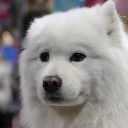

In [20]:
cv2_imshow(cv2.resize(cv2.imread(train['image_path'][1]),(128,128)))

In [85]:
LR=1e-4
batch_size=16
EPOCHS=10

Make the data ready using torch dataloaders for NN

In [96]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

Define the network

In [102]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2=nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3=nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv4=nn.Conv2d(128, 64, kernel_size=3, padding=1)

    self.pool=nn.MaxPool2d(2,2)

    self.relu=nn.ReLU()

    self.flatten=nn.Flatten()

    self.linear = nn.Linear((64*8*8), 64)

    self.output = nn.Linear(64, 3)

  def forward(self, x):

    x=self.conv1(x) # -> 32, 128, 128
    x=self.pool(x)  # -> 32, 64, 64
    x=self.relu(x)  # -> 32, 64, 64

    x=self.conv2(x) # -> 64, 64, 64
    x=self.pool(x)  # -> 64, 32, 32
    x=self.relu(x)  # -> 64, 32, 32

    x=self.conv3(x) # -> 128, 32, 32
    x=self.pool(x)  # -> 128, 16, 16
    x=self.relu(x)  # -> 128, 16, 16

    x=self.conv4(x) # -> 64, 16, 16
    x=self.pool(x)  # -> 64, 8, 8
    x=self.relu(x)  # -> 64, 8, 8

    x=self.flatten(x)
    x=self.linear(x)
    x=self.output(x)

    return x


In [104]:
model=Net().to(device)

In [105]:
summary(model, input_size= (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          73,792
        MaxPool2d-11             [-1, 64, 8, 8]               0
             ReLU-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                   

Define the loss function and optimizer

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [107]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  total_loss_train=0
  total_acc_train=0
  total_loss_validation=0
  total_acc_validation=0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc=(torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      validation_loss = criterion(outputs, labels)
      total_loss_validation += validation_loss.item()


      validation_acc=(torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_validation += validation_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))
  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100, 4))
  total_acc_validation_plot.append(round((total_acc_validation/val_dataset.__len__()) * 100, 4))

  print(f'''Epoch {epoch + 1}/{EPOCHS}, Training Loss : {round(total_loss_train/1000, 4)} Training Accuracy : {round((total_acc_train/train_dataset.__len__()) * 100, 4)}
        Validation Loss : {round(total_loss_validation/1000, 4)} Validation Accuracy : {round((total_acc_validation/val_dataset.__len__()) * 100, 4)}''')

Epoch 1/10, Training Loss : 0.4614 Training Accuracy : 70.6758
        Validation Loss : 0.0651 Validation Accuracy : 84.291
Epoch 2/10, Training Loss : 0.2117 Training Accuracy : 89.0001
        Validation Loss : 0.045 Validation Accuracy : 88.2183
Epoch 3/10, Training Loss : 0.1469 Training Accuracy : 92.4807
        Validation Loss : 0.0293 Validation Accuracy : 93.2203
Epoch 4/10, Training Loss : 0.1208 Training Accuracy : 93.8092
        Validation Loss : 0.0263 Validation Accuracy : 94.1711
Epoch 5/10, Training Loss : 0.0964 Training Accuracy : 95.12
        Validation Loss : 0.0276 Validation Accuracy : 93.427
Epoch 6/10, Training Loss : 0.0825 Training Accuracy : 95.8374
        Validation Loss : 0.0247 Validation Accuracy : 94.2952
Epoch 7/10, Training Loss : 0.0681 Training Accuracy : 96.6433
        Validation Loss : 0.0237 Validation Accuracy : 94.5019
Epoch 8/10, Training Loss : 0.058 Training Accuracy : 97.0773
        Validation Loss : 0.0226 Validation Accuracy : 94.956

Check the accuracy for test dataset

In [109]:
  with torch.no_grad():
    total_acc_test=0
    total_loss_test=0

    for inputs, labels in test_loader:
      outputs = model(inputs)

      test_loss = criterion(outputs, labels)
      total_loss_test += test_loss.item()


      test_acc=(torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_test += test_acc


  print(f'''Accuracy Score is:  {round((total_acc_test/test_dataset.__len__()) * 100, 4)}''')

Accuracy Score is:  96.7769


Plot the loss and accuracy

Text(0.5, 1.0, 'Traning and Validation Accuracy over Epochs')

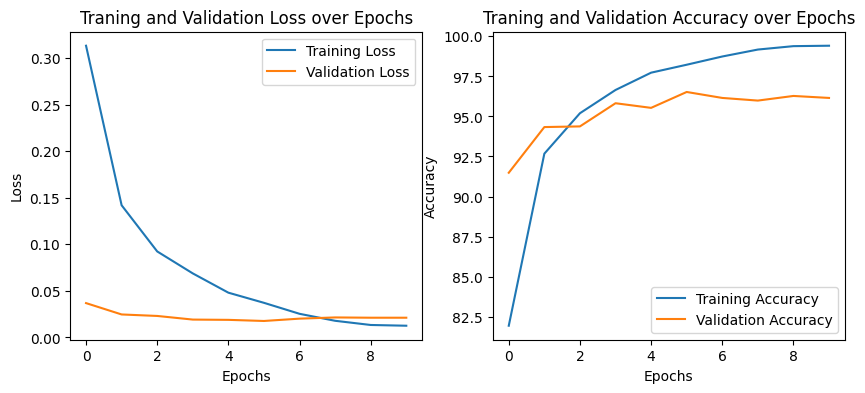

In [31]:
fig, axis=plt.subplots(1,2, figsize=(10,4))

axis[0].plot(total_loss_train_plot, label='Training Loss')
axis[0].plot(total_loss_validation_plot, label='Validation Loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_title('Traning and Validation Loss over Epochs')
axis[0].legend()

axis[1].plot(total_acc_train_plot, label='Training Accuracy')
axis[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()
axis[1].set_title('Traning and Validation Accuracy over Epochs')

Inference

In [110]:
def predict_image(image_path):
  image=Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output=model(image.unsqueeze(0)) #first paramater needs to be batch size, hence unsqueeze

  return label_encoder.inverse_transform([torch.argmax(output, axis=1).item()])

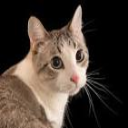

In [111]:
cv2_imshow(cv2.resize(cv2.imread('/content/cat.jpeg'),(128,128)))

In [112]:
predict_image("/content/cat.jpeg")

array(['cat'], dtype=object)

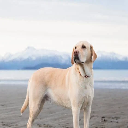

In [120]:
cv2_imshow(cv2.resize(cv2.imread('/content/dog.jpg'),(128,128)))

In [121]:
predict_image("/content/dog.jpg")

array(['dog'], dtype=object)

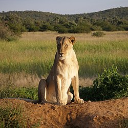

In [125]:
cv2_imshow(cv2.resize(cv2.imread('/content/lioness.jpg'),(128,128)))

In [124]:
predict_image("/content/lioness.jpg")

array(['wild'], dtype=object)